# Solar Irradiance Forecasting Project
## Step 1 — Load the Data

In this cell we will:
- import all required libraries
- read the file `mydata.csv` from the path `/mnt/data/`
- inspect its columns and shape
- display first few rows

Make sure the file exists in the path shown.


In [1]:


pip install prophet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
import joblib
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.statespace.sarimax import SARIMAX

from prophet import Prophet

# XGBoost
from xgboost import XGBRegressor


# ---- Load data ----
DATA_PATH = "mydata.csv"

df = pd.read_csv(DATA_PATH)

print("Dataset loaded successfully!")
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

df.head()


Importing plotly failed. Interactive plots will not work.


Dataset loaded successfully!
Shape: (8736, 11)
Columns: ['YEAR', 'MO', 'DY', 'HR', 'ALLSKY_SFC_SW_DWN', 'T2M', 'RH2M', 'PS', 'WS10M', 'T2MDEW', 'SZA']


,YEAR,MO,DY,HR,ALLSKY_SFC_SW_DWN,T2M,RH2M,PS,WS10M,T2MDEW,SZA
0,2024,10,1,0,0.0,21.80,85.58,97.72,2.07,19.28,90.0
1,2024,10,1,1,0.0,21.78,86.30,97.68,2.05,19.40,90.0
2,2024,10,1,2,0.0,21.70,88.49,97.66,2.19,19.72,90.0
3,2024,10,1,3,0.0,21.56,91.03,97.65,2.40,20.04,90.0
4,2024,10,1,4,0.0,21.49,93.17,97.65,2.58,20.35,90.0


## Step 2 — Build `timestamp` column and set it as index

In this step we will:

- Combine the columns YEAR, MO, DY, HR into a single datetime column.
- Sort the data by time in ascending order.
- Set the new `timestamp` column as the DataFrame index.

This is important for all time–series models.


In [3]:
# Target column name (solar irradiance)
TARGET_COL = "ALLSKY_SFC_SW_DWN"

# Build timestamp from YEAR, MO, DY, HR
df["timestamp"] = pd.to_datetime(
    {
        "year": df["YEAR"],
        "month": df["MO"],
        "day": df["DY"],
        "hour": df["HR"],
    }
)

# Sort by time and set as index
df = df.sort_values("timestamp").reset_index(drop=True)
df = df.set_index("timestamp")

print("Index type:", type(df.index))
print("Start:", df.index.min(), "  End:", df.index.max())
print("Shape after adding timestamp:", df.shape)

df.head()


Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Start: 2024-10-01 00:00:00   End: 2025-09-29 23:00:00
Shape after adding timestamp: (8736, 11)


,YEAR,MO,DY,HR,ALLSKY_SFC_SW_DWN,T2M,RH2M,PS,WS10M,T2MDEW,SZA
timestamp,,,,,,,,,,,
2024-10-01 00:00:00,2024,10,1,0,0.0,21.80,85.58,97.72,2.07,19.28,90.0
2024-10-01 01:00:00,2024,10,1,1,0.0,21.78,86.30,97.68,2.05,19.40,90.0
2024-10-01 02:00:00,2024,10,1,2,0.0,21.70,88.49,97.66,2.19,19.72,90.0
2024-10-01 03:00:00,2024,10,1,3,0.0,21.56,91.03,97.65,2.40,20.04,90.0
2024-10-01 04:00:00,2024,10,1,4,0.0,21.49,93.17,97.65,2.58,20.35,90.0


## Step 3 — Basic cleaning and selecting useful columns

Here we will:

- Make sure the target column is numeric.
- Keep only the columns we care about for now:
  - YEAR, MO, DY, HR
  - ALLSKY_SFC_SW_DWN (target)
  - T2M, RH2M, PS, WS10M, T2MDEW, SZA (weather features)
- Drop rows where the target is missing (`NaN`).

We can always improve cleaning later, but this is a good start.


In [4]:
# Ensure target is numeric
df[TARGET_COL] = pd.to_numeric(df[TARGET_COL], errors="coerce")

# Keep only useful columns
cols_to_keep = [
    "YEAR", "MO", "DY", "HR",
    TARGET_COL,
    "T2M", "RH2M", "PS", "WS10M", "T2MDEW", "SZA"
]
existing_cols = [c for c in cols_to_keep if c in df.columns]

df = df[existing_cols].copy()

# Drop rows where target is NaN
df = df.dropna(subset=[TARGET_COL])

print("Columns after cleaning:", df.columns.tolist())
print("Shape after cleaning:", df.shape)

df.head()


Columns after cleaning: ['YEAR', 'MO', 'DY', 'HR', 'ALLSKY_SFC_SW_DWN', 'T2M', 'RH2M', 'PS', 'WS10M', 'T2MDEW', 'SZA']
Shape after cleaning: (8736, 11)


,YEAR,MO,DY,HR,ALLSKY_SFC_SW_DWN,T2M,RH2M,PS,WS10M,T2MDEW,SZA
timestamp,,,,,,,,,,,
2024-10-01 00:00:00,2024,10,1,0,0.0,21.80,85.58,97.72,2.07,19.28,90.0
2024-10-01 01:00:00,2024,10,1,1,0.0,21.78,86.30,97.68,2.05,19.40,90.0
2024-10-01 02:00:00,2024,10,1,2,0.0,21.70,88.49,97.66,2.19,19.72,90.0
2024-10-01 03:00:00,2024,10,1,3,0.0,21.56,91.03,97.65,2.40,20.04,90.0
2024-10-01 04:00:00,2024,10,1,4,0.0,21.49,93.17,97.65,2.58,20.35,90.0


## Step 4 — Quick Exploratory Data Analysis (EDA)

In this step we will:
- Plot the irradiance over time
- Plot the first 500 hours for more detail
- Plot daily average irradiance

This helps us visually confirm:
- Daily solar cycle
- Missing nighttime patterns
- Seasonal or long-term trends


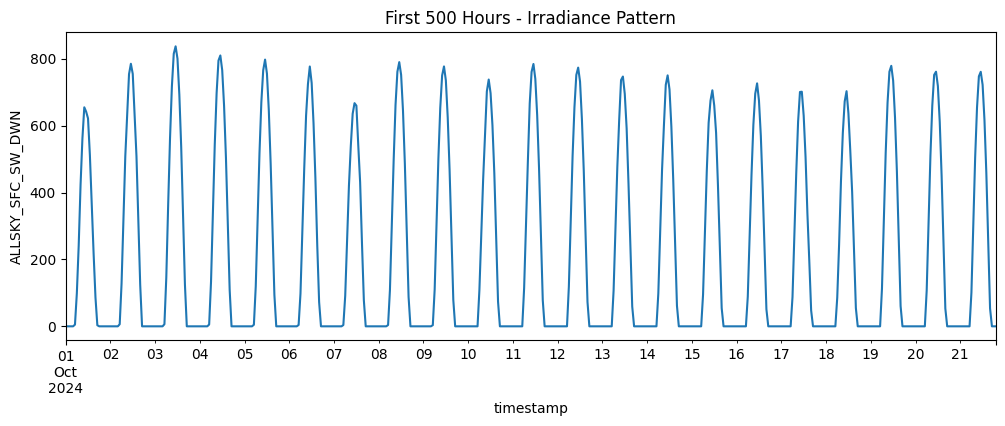

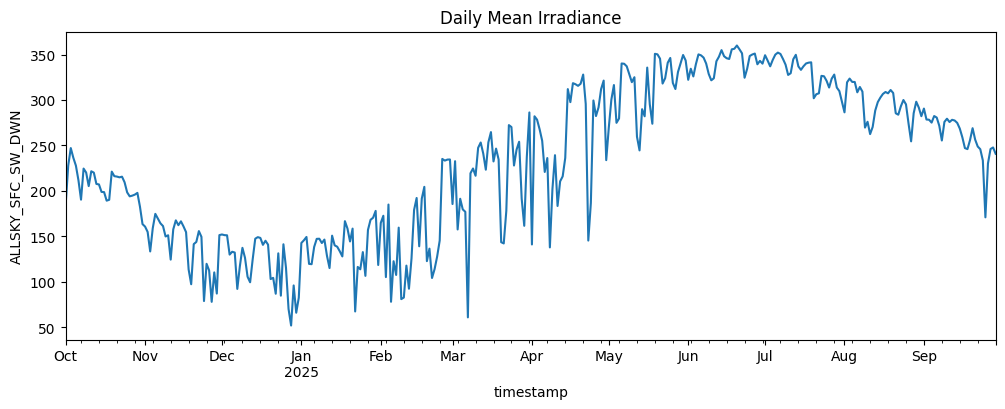

In [5]:
# Plot first 500 hours to see pattern
df[TARGET_COL].iloc[:500].plot(figsize=(12,4))
plt.title("First 500 Hours - Irradiance Pattern")
plt.ylabel(TARGET_COL)
plt.show()

# Plot daily average
df_daily = df[TARGET_COL].resample("D").mean()
df_daily.plot(figsize=(12,4))
plt.title("Daily Mean Irradiance")
plt.ylabel(TARGET_COL)
plt.show()


## Step 5 — Create time-based features

To help ML models detect patterns in time, we add:

- Hour of day → sine & cosine
- Day of year → sine & cosine

These capture:
- Daily periodicity
- Yearly seasonal cycle


In [6]:
# Hour and day of year
df["hour"] = df.index.hour
df["dayofyear"] = df.index.dayofyear

# Encode hour as sin/cos
df["hour_sin"]     = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"]     = np.cos(2 * np.pi * df["hour"] / 24)

# Encode day-of-year as sin/cos
df["day_sin"]      = np.sin(2 * np.pi * df["dayofyear"] / 365)
df["day_cos"]      = np.cos(2 * np.pi * df["dayofyear"] / 365)

df[["hour","dayofyear","hour_sin","hour_cos","day_sin","day_cos"]].head()


,hour,dayofyear,hour_sin,hour_cos,day_sin,day_cos
timestamp,,,,,,
2024-10-01 00:00:00,0,275,0.000000,1.000000,-0.999769,0.021516
2024-10-01 01:00:00,1,275,0.258819,0.965926,-0.999769,0.021516
2024-10-01 02:00:00,2,275,0.500000,0.866025,-0.999769,0.021516
2024-10-01 03:00:00,3,275,0.707107,0.707107,-0.999769,0.021516
2024-10-01 04:00:00,4,275,0.866025,0.500000,-0.999769,0.021516


## Step 6 — Create lag features + rolling mean

We now engineer feature columns built from **past values** of the target:

Lags:
- 1h
- 2h
- 3h
- 6h
- 24h

Rolling mean:
- Mean irradiance of previous 24 hours
- Using `.shift(1).rolling()` to avoid leakage

⚠️ After creating these features, we drop rows with NaN values.


In [7]:
lags = [1, 2, 3, 6, 24]

# Create lag features
for lag in lags:
    df[f"lag_{lag}h"] = df[TARGET_COL].shift(lag)

# Rolling mean (past 24h)
df["rolling_24h_mean"] = df[TARGET_COL].shift(1).rolling(window=24, min_periods=12).mean()

# Drop rows with missing feature values
df = df.dropna().copy()

print("Shape after lag/rolling:", df.shape)
df.head()


Shape after lag/rolling: (8712, 23)


,YEAR,MO,DY,HR,ALLSKY_SFC_SW_DWN,T2M,RH2M,PS,WS10M,T2MDEW,...,hour_sin,hour_cos,day_sin,day_cos,lag_1h,lag_2h,lag_3h,lag_6h,lag_24h,rolling_24h_mean
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-10-02 00:00:00,2024,10,2,0,0.0,20.98,75.54,97.78,4.09,16.51,...,0.000000,1.000000,-0.99925,0.038722,0.0,0.0,0.0,0.0,0.0,184.65375
2024-10-02 01:00:00,2024,10,2,1,0.0,20.86,75.53,97.77,3.98,16.38,...,0.258819,0.965926,-0.99925,0.038722,0.0,0.0,0.0,0.0,0.0,184.65375
2024-10-02 02:00:00,2024,10,2,2,0.0,20.73,75.81,97.75,3.80,16.31,...,0.500000,0.866025,-0.99925,0.038722,0.0,0.0,0.0,0.0,0.0,184.65375
2024-10-02 03:00:00,2024,10,2,3,0.0,20.57,76.31,97.77,3.58,16.27,...,0.707107,0.707107,-0.99925,0.038722,0.0,0.0,0.0,0.0,0.0,184.65375
2024-10-02 04:00:00,2024,10,2,4,0.0,20.44,76.43,97.79,3.32,16.18,...,0.866025,0.500000,-0.99925,0.038722,0.0,0.0,0.0,0.0,0.0,184.65375


## Step 7 — Time-based Train/Test Split + Metric Functions

We now:

1. Build a clean feature matrix `X` and target vector `y`
2. Split the data chronologically:
   - First 80% → training
   - Last 20% → testing (future)
3. Define metrics:
   - MAE
   - RMSE
   - R²

This lets us evaluate all models consistently.


In [8]:
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Target and feature separation
feature_cols = [c for c in df.columns if c != TARGET_COL]

X = df[feature_cols].copy()
y = df[TARGET_COL].copy()

# Split index (80% train, 20% test)
split_idx = int(len(df) * 0.8)

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape :", X_test.shape, y_test.shape)

def evaluate_metrics(y_true, y_pred, name="Model"):
    """
    Compute MAE, RMSE, R² for given true and predicted values.
    (RMSE is computed manually from MSE to avoid using squared=False)
    """
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)   # no squared argument here
    rmse = sqrt(mse)                           # manual RMSE
    r2 = r2_score(y_true, y_pred)
    print(f"\n=== {name} ===")
    print(f"MAE : {mae:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"R²  : {r2:.3f}")
    return {"Model": name, "MAE": mae, "RMSE": rmse, "R2": r2}


Train shape: (6969, 22) (6969,)
Test shape : (1743, 22) (1743,)


## Step 8 — SARIMA baseline model (Univariate)

We start with the simplest time-series model:
- Only uses historical irradiance values
- Ignores weather & engineered features

SARIMA parameters:
- order = (1,1,1)
- seasonal_order = (1,1,1,24)

📌 These settings assume hourly data with daily seasonality.
You can tune later for better performance.


In [9]:
# === SARIMA baseline (univariate) ===
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 24)

sarima_model = SARIMAX(
    endog=y_train,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

sarima_forecast = sarima_model.forecast(steps=len(y_test))

sarima_results = evaluate_metrics(y_test, sarima_forecast, name="SARIMA")

print("\nSARIMA model completed.")


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)



=== SARIMA ===
MAE : 54.813
RMSE: 83.532
R²  : 0.942

SARIMA model completed.


## Step 9 — SARIMAX with time-based exogenous features

Now we extend SARIMA → SARIMAX by adding **time features** as exogenous variables:

We will use:
- `hour_sin`, `hour_cos`
- `day_sin`, `day_cos`

These features:
- Are known for the future timestamps
- Help the model learn daily and yearly seasonality

We do **not** use lag or rolling features here, because SARIMAX already uses past values internally.


In [10]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# === Prepare data for SARIMAX (weather features only) ===

# نشتغل على نسخة من الداتا
df_sarimax = df.copy()

# نتأكد إنه timestamp هو الـ index
df_sarimax = df_sarimax.sort_index()

# الهدف والـ exogenous variables
y = df_sarimax[TARGET_COL]

exog_cols_weather = ["T2M", "RH2M", "PS", "WS10M", "T2MDEW", "SZA"]
exog_cols_weather = [c for c in exog_cols_weather if c in df_sarimax.columns]

X = df_sarimax[exog_cols_weather]

# Drop NaNs from trainable block
mask = y.notna() & X.notna().all(axis=1)
y = y[mask]
X = X[mask]

# Split using the same split_idx defined earlier
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]

print("Train shapes:", y_train.shape, X_train.shape)
print("Test  shapes:", y_test.shape, X_test.shape)

# Fit SARIMAX
sarimax_model = SARIMAX(
    endog=y_train,
    exog=X_train,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

# Forecast same length as test using exog
sarimax_forecast = sarimax_model.get_forecast(
    steps=len(y_test),
    exog=X_test
).predicted_mean

# Align index
sarimax_forecast = sarimax_forecast.reindex(y_test.index)

# Evaluate
sarimax_results = evaluate_metrics(y_test, sarimax_forecast, name="SARIMAX (weather exog)")

print("\nSARIMAX DONE.")


Train shapes: (6969,) (6969, 6)
Test  shapes: (1743,) (1743, 6)


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



=== SARIMAX (weather exog) ===
MAE : 103.400
RMSE: 118.522
R²  : 0.883

SARIMAX DONE.


## Step 10 — Prophet model

Prophet requires the data to be structured with:
- `ds`: a datetime column
- `y` : the target variable

In this step we will:

1. Build a new DataFrame for Prophet using:
   - `ds` = timestamp
   - `y` = ALLSKY_SFC_SW_DWN

2. Split it using the same `split_idx` (80% train / 20% test)

3. Fit Prophet on the training portion only

4. Generate future timestamps equal to the test size

5. Retrieve predictions for the test period

6. Evaluate predictions (MAE, RMSE, R²)


In [11]:
from prophet import Prophet

# === Prepare data for Prophet ===
# Create a DataFrame with Prophet's required column names:
# - ds = datetime column
# - y  = target values
df_prophet = pd.DataFrame({
    "ds": df.index,                 # timestamps already sorted and filtered
    "y": df[TARGET_COL].values      # target: ALLSKY_SFC_SW_DWN
})

# Split the Prophet dataframe using the same split index
df_prophet_train = df_prophet.iloc[:split_idx]
df_prophet_test  = df_prophet.iloc[split_idx:]

print("Prophet train shape:", df_prophet_train.shape)
print("Prophet test  shape:", df_prophet_test.shape)

# === Build and fit Prophet model ===
prophet_model = Prophet(
    daily_seasonality=True,     # learns daily cycles
    weekly_seasonality=True,    # learns weekly patterns
    yearly_seasonality=True     # learns yearly trends
)

prophet_model.fit(df_prophet_train)

# === Create a future dataframe ===
# periods = number of timestamps in the test set
# freq="H" means hourly future timestamps
future = prophet_model.make_future_dataframe(
    periods=len(df_prophet_test),
    freq="H"
)

# Get Prophet's predictions over all (train + test) dates
forecast = prophet_model.predict(future)

# Extract only the test portion of prophet forecast
forecast_test = forecast.iloc[-len(df_prophet_test):].set_index("ds")["yhat"]

# Align predicted values with true test target using the timestamp index
prophet_pred = forecast_test.reindex(y_test.index)

# === Evaluate Prophet performance ===
prophet_results = evaluate_metrics(y_test, prophet_pred, name="Prophet")

print("\nProphet model completed.")


Prophet train shape: (6969, 2)
Prophet test  shape: (1743, 2)


01:36:32 - cmdstanpy - INFO - Chain [1] start processing
01:36:33 - cmdstanpy - INFO - Chain [1] done processing



=== Prophet ===
MAE : 374.558
RMSE: 450.836
R²  : -0.699

Prophet model completed.


## Step 11 — Random Forest Regressor (all useful features)

Now we train a machine learning model (Random Forest) using:

### Input features:
- Weather variables:
  - T2M, RH2M, PS, WS10M, T2MDEW, SZA
- Time encodings:
  - hour_sin, hour_cos, day_sin, day_cos
- Lag-based features:
  - lag_1h, lag_2h, lag_3h, lag_6h, lag_24h
- Rolling window:
  - rolling_24h_mean

### Why Random Forest?
- Handles non-linear patterns
- Can combine weather + lag + time features
- Fast and reliable baseline before XGBoost


In [12]:
from sklearn.ensemble import RandomForestRegressor

# Define which columns we want to use as features for Random Forest
rf_feature_cols = [
    "T2M", "RH2M", "PS", "WS10M", "T2MDEW", "SZA",
    "hour_sin", "hour_cos", "day_sin", "day_cos",
    "lag_1h", "lag_2h", "lag_3h", "lag_6h", "lag_24h",
    "rolling_24h_mean"
]

# Keep only columns that actually exist in the training dataframe
rf_feature_cols = [c for c in rf_feature_cols if c in X_train.columns]

# Initialize the Random Forest model
rf = RandomForestRegressor(
    n_estimators=100,      # number of trees
    max_depth=5,        # allow full growth
    random_state=42,       # reproducibility
    n_jobs=-1              # use all CPU cores
)

# Train the model
rf.fit(X_train[rf_feature_cols], y_train)

# Predict on the test set
rf_pred = rf.predict(X_test[rf_feature_cols])

# Evaluate model
rf_results = evaluate_metrics(y_test, rf_pred, name="Random Forest")

print("\nRandom Forest model completed.")



=== Random Forest ===
MAE : 16.815
RMSE: 31.176
R²  : 0.992

Random Forest model completed.


## Step 12 — XGBoost Regressor (same feature set as Random Forest)

Now we train an XGBoost model using **exactly the same features** as Random Forest:

### Features:
- Weather features (T2M, RH2M, PS, WS10M, T2MDEW, SZA)
- Time encodings (hour_sin, hour_cos, day_sin, day_cos)
- Lagged features (lag_1h, lag_2h, lag_3h, lag_6h, lag_24h)
- Rolling window feature (rolling_24h_mean)

### Why XGBoost?
- Often performs better than Random Forest
- Handles non-linearity + interactions strongly
- Can capture sharp spikes and dips in irradiance


In [13]:
from xgboost import XGBRegressor

# Use the exact same features as Random Forest
xgb_feature_cols = rf_feature_cols

# Initialize XGBoost Regressor
xgb = XGBRegressor(
    n_estimators=100,         # number of boosting rounds
    max_depth=5,              # max tree depth
    learning_rate=0.05,       # shrinkage rate
    subsample=0.9,            # sample of rows per tree
    colsample_bytree=0.9,     # sample of features per tree
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

# Train XGBoost
xgb.fit(X_train[xgb_feature_cols], y_train)

# Predict on test set
xgb_pred = xgb.predict(X_test[xgb_feature_cols])

# Evaluate model performance
xgb_results = evaluate_metrics(y_test, xgb_pred, name="XGBoost")

print("\nXGBoost model completed.")



=== XGBoost ===
MAE : 24.707
RMSE: 39.370
R²  : 0.987

XGBoost model completed.


## Step 13 — Compare all model performances

Now that we have trained all models:

- SARIMA

- SARIMAX
- Prophet
- Random Forest
- XGBoost

We will:
1. Combine their evaluation results into a single table
2. Sort by **RMSE** (lower = better)
3. Print the results for comparison

This helps us identify which model is most accurate for our dataset.


In [14]:
# Combine all result dictionaries into a list
results_list = [
    sarima_results,
    sarimax_results,
    prophet_results,
    rf_results,
    xgb_results
]

# Convert list to DataFrame
results_df = pd.DataFrame(results_list)

# Sort models by RMSE (best at the top)
results_df = results_df.sort_values("RMSE").reset_index(drop=True)

print("\n=== Model Comparison (sorted by RMSE) ===")
display(results_df)



=== Model Comparison (sorted by RMSE) ===


,Model,MAE,RMSE,R2
0,Random Forest,16.814616,31.176363,0.991875
1,XGBoost,24.707065,39.370412,0.987042
2,SARIMA,54.813334,83.531949,0.941670
3,SARIMAX (weather exog),103.399858,118.522251,0.882569
4,Prophet,374.558427,450.836295,-0.699112


## Step 15 — Walk-Forward Validation (Random Forest)

Instead of training on one train/test split only,
walk-forward validation simulates real forecasting:

Fold 1:
- Train on 0 → 60%
- Test 60 → 70%

Fold 2:
- Train on 0 → 70%
- Test 70 → 80%

Fold 3:
- Train on 0 → 80%
- Test 80 → 90%

Fold 4:
- Train on 0 → 90%
- Test 90 → 100%

For each fold:
1. Train Random Forest only on data available up to that point
2. Predict the next block (future data)
3. Compute MAE, RMSE, R²
4. Store scores

Finally:
- Print results per fold
- Compute the average performance (mean RMSE)


In [15]:
from sklearn.ensemble import RandomForestRegressor

# Number of walk-forward folds
n_folds = 4

# List to store results from each fold
wf_results = []

# Convert X and y to numpy for indexing safety
X_arr = X_train.values
y_arr = y_train.values

# Compute fold boundaries based on train set only
fold_size = len(y_arr) // (n_folds + 1)

print(f"Total train points: {len(y_arr)}, Fold size: {fold_size}")

for fold in range(n_folds):
    # Determine expanding train window end
    train_end = (fold + 1) * fold_size
    
    # Determine test window
    test_start = train_end
    test_end = train_end + fold_size
    
    # Safety clip
    if test_end > len(y_arr):
        test_end = len(y_arr)
    
    # Skip if no valid test block remains
    if test_start >= test_end:
        break
    
    # Split data
    X_train_fold = X_arr[:train_end]
    y_train_fold = y_arr[:train_end]
    
    X_test_fold  = X_arr[test_start:test_end]
    y_test_fold  = y_arr[test_start:test_end]

    # Train RF on current fold
    rf_fold = RandomForestRegressor(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    )

    rf_fold.fit(X_train_fold, y_train_fold)
    preds = rf_fold.predict(X_test_fold)

    # Evaluate fold
    fold_result = evaluate_metrics(y_test_fold, preds, name=f"RF Fold {fold+1}")
    wf_results.append(fold_result)

# Convert walk-forward results to a DataFrame
wf_df = pd.DataFrame(wf_results)
print("\n=== Walk-Forward Results (RF) ===")
display(wf_df)

# Print average performance across folds
print(f"\nAverage RMSE: {wf_df['RMSE'].mean():.3f}")
print(f"Std RMSE     : {wf_df['RMSE'].std():.3f}")


Total train points: 6969, Fold size: 1393

=== RF Fold 1 ===
MAE : 25.330
RMSE: 53.851
R²  : 0.918

=== RF Fold 2 ===
MAE : 32.755
RMSE: 75.148
R²  : 0.909

=== RF Fold 3 ===
MAE : 42.433
RMSE: 85.206
R²  : 0.935

=== RF Fold 4 ===
MAE : 64.824
RMSE: 116.469
R²  : 0.907

=== Walk-Forward Results (RF) ===


,Model,MAE,RMSE,R2
0,RF Fold 1,25.330063,53.851433,0.918264
1,RF Fold 2,32.755118,75.148487,0.909347
2,RF Fold 3,42.432612,85.205859,0.934858
3,RF Fold 4,64.823585,116.468746,0.907079



Average RMSE: 82.669
Std RMSE     : 26.050


## Step 16 — Walk-Forward Validation (XGBoost)

We now repeat walk-forward validation for **XGBoost**, using the same idea:

- Use only the **training part** of the data (first 80%)
- Split it into 4 folds with an **expanding window**:
  - Fold 1: train on earliest block, test on next block
  - Fold 2: train on a larger block, test on the next block
  - ...
- For each fold:
  1. Train XGBoost on the current training window
  2. Predict on the next future block
  3. Compute MAE, RMSE, R²
  4. Store the results

At the end:
- Display a table with the scores for each fold
- Compute **mean RMSE** and **standard deviation** across folds


In [16]:
from xgboost import XGBRegressor

# Use the same feature set used before for XGBoost
xgb_feature_cols = rf_feature_cols  # same as RF features

# Extract only the training portion for walk-forward (80%)
X_wf = X_train[xgb_feature_cols].copy()
y_wf = y_train.copy()

# Convert to numpy arrays for easier slicing
X_arr = X_wf.values
y_arr = y_wf.values

n_folds = 4
fold_size = len(y_arr) // (n_folds + 1)

print(f"Total train points: {len(y_arr)}, Fold size: {fold_size}")

wf_xgb_results = []

for fold in range(n_folds):
    # Determine expanding train window end
    train_end = (fold + 1) * fold_size

    # Determine test window
    test_start = train_end
    test_end = train_end + fold_size

    # Clip to maximum length
    if test_end > len(y_arr):
        test_end = len(y_arr)

    # Stop if no test range left
    if test_start >= test_end:
        break

    # Create fold splits
    X_train_fold = X_arr[:train_end]
    y_train_fold = y_arr[:train_end]

    X_test_fold  = X_arr[test_start:test_end]
    y_test_fold  = y_arr[test_start:test_end]

    # Initialize XGBoost model
    xgb_fold = XGBRegressor(
        n_estimators=100,          
        max_depth=5,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1
    )

    # Fit and predict
    xgb_fold.fit(X_train_fold, y_train_fold)
    preds = xgb_fold.predict(X_test_fold)

    # Evaluate this fold
    fold_result = evaluate_metrics(y_test_fold, preds, name=f"XGB Fold {fold+1}")
    wf_xgb_results.append(fold_result)

# Convert to DataFrame for summary
wf_xgb_df = pd.DataFrame(wf_xgb_results)
print("\n=== Walk-Forward Results (XGBoost) ===")
display(wf_xgb_df)

# Average performance
print(f"\nAverage RMSE: {wf_xgb_df['RMSE'].mean():.3f}")
print(f"Std RMSE     : {wf_xgb_df['RMSE'].std():.3f}")


Total train points: 6969, Fold size: 1393

=== XGB Fold 1 ===
MAE : 36.953
RMSE: 65.033
R²  : 0.881

=== XGB Fold 2 ===
MAE : 32.074
RMSE: 63.480
R²  : 0.935

=== XGB Fold 3 ===
MAE : 45.836
RMSE: 83.120
R²  : 0.938

=== XGB Fold 4 ===
MAE : 73.822
RMSE: 124.713
R²  : 0.893

=== Walk-Forward Results (XGBoost) ===


,Model,MAE,RMSE,R2
0,XGB Fold 1,36.953454,65.033183,0.880796
1,XGB Fold 2,32.073753,63.479842,0.935313
2,XGB Fold 3,45.836031,83.120346,0.938008
3,XGB Fold 4,73.821541,124.712605,0.893459



Average RMSE: 84.086
Std RMSE     : 28.514


## Compare Random Forest vs XGBoost after Walk-Forward Validation

We already have:

- `wf_df`      → walk-forward results for Random Forest (one row per fold)
- `wf_xgb_df`  → walk-forward results for XGBoost (one row per fold)

In this step we will:

1. Compute, for each model:
   - Mean MAE, RMSE, R² across folds
   - Standard deviation of RMSE across folds
2. Build a summary comparison table:
   - One row for Random Forest
   - One row for XGBoost
3. Optionally sort by RMSE (lower is better)

This gives us a clean, side-by-side comparison of both models **after** realistic walk-forward validation.


In [17]:
# Make sure the DataFrames from walk-forward exist:
# - wf_df      : RF folds
# - wf_xgb_df  : XGB folds

print("Random Forest WF results:")
display(wf_df)

print("XGBoost WF results:")
display(wf_xgb_df)

# Compute summary stats for RF
rf_mean_mae  = wf_df["MAE"].mean()
rf_mean_rmse = wf_df["RMSE"].mean()
rf_mean_r2   = wf_df["R2"].mean()
rf_std_rmse  = wf_df["RMSE"].std()

# Compute summary stats for XGB
xgb_mean_mae  = wf_xgb_df["MAE"].mean()
xgb_mean_rmse = wf_xgb_df["RMSE"].mean()
xgb_mean_r2   = wf_xgb_df["R2"].mean()
xgb_std_rmse  = wf_xgb_df["RMSE"].std()

# Build comparison DataFrame
comparison_df = pd.DataFrame([
    {
        "Model": "Random Forest",
        "Mean_MAE": rf_mean_mae,
        "Mean_RMSE": rf_mean_rmse,
        "Mean_R2": rf_mean_r2,
        "Std_RMSE": rf_std_rmse
    },
    {
        "Model": "XGBoost",
        "Mean_MAE": xgb_mean_mae,
        "Mean_RMSE": xgb_mean_rmse,
        "Mean_R2": xgb_mean_r2,
        "Std_RMSE": xgb_std_rmse
    }
])

# Sort by Mean_RMSE (best model on top)
comparison_df = comparison_df.sort_values("Mean_RMSE").reset_index(drop=True)

print("\n=== RF vs XGB – Walk-Forward Summary ===")
display(comparison_df)


Random Forest WF results:


,Model,MAE,RMSE,R2
0,RF Fold 1,25.330063,53.851433,0.918264
1,RF Fold 2,32.755118,75.148487,0.909347
2,RF Fold 3,42.432612,85.205859,0.934858
3,RF Fold 4,64.823585,116.468746,0.907079


XGBoost WF results:


,Model,MAE,RMSE,R2
0,XGB Fold 1,36.953454,65.033183,0.880796
1,XGB Fold 2,32.073753,63.479842,0.935313
2,XGB Fold 3,45.836031,83.120346,0.938008
3,XGB Fold 4,73.821541,124.712605,0.893459



=== RF vs XGB – Walk-Forward Summary ===


,Model,Mean_MAE,Mean_RMSE,Mean_R2,Std_RMSE
0,Random Forest,41.335344,82.668631,0.917387,26.050392
1,XGBoost,47.171195,84.086494,0.911894,28.513606


## Step 17 — Train final Random Forest on all data and save the model

From the previous comparison and walk-forward validation:

- Random Forest is the best overall model.

In this step we will:

1. Train a **final Random Forest model** using **all available data**  
   (full `X` and `y`, not only the train split).
2. Use the same feature set `rf_feature_cols` that we used before.
3. Save a dictionary containing:
   - the trained model object
   - the list of feature names (to build inputs correctly later)
4. Store it as: `rf_best_model.pkl` using `joblib.dump`.

This file will be loaded later in the backend of the website to:
- predict future irradiance
- convert irradiance to energy (kWh)


In [18]:
import joblib
from sklearn.ensemble import RandomForestRegressor

# Define the full feature set again (same as RF training earlier)
rf_feature_cols = [
    "T2M", "RH2M", "PS", "WS10M", "T2MDEW", "SZA",
    "hour_sin", "hour_cos", "day_sin", "day_cos",
    "lag_1h", "lag_2h", "lag_3h", "lag_6h", "lag_24h",
    "rolling_24h_mean"
]

# Filter columns that exist
rf_feature_cols = [c for c in rf_feature_cols if c in df.columns]

print("Using features:", rf_feature_cols)

# Build full feature matrix and target using ALL rows
X_full = df[rf_feature_cols].copy()
y_full = df[TARGET_COL].copy()

print("Full shapes:", X_full.shape, y_full.shape)

# Drop any NaNs introduced by lag/rolling
mask_full = X_full.notna().all(axis=1) & y_full.notna()
X_full = X_full[mask_full]
y_full = y_full[mask_full]

print("After dropping NaNs:", X_full.shape, y_full.shape)

# Train FINAL RF model with full feature set
rf_final = RandomForestRegressor(
    n_estimators=100,
    max_depth=5,
    random_state=42,
    n_jobs=-1
)

rf_final.fit(X_full, y_full)

rf_package = {
    "model": rf_final,
    "features": rf_feature_cols,
    "target_name": TARGET_COL
}

MODEL_PATH = "rf_best_model.pkl"
joblib.dump(rf_package, MODEL_PATH)

print("\nFINAL Random Forest with full engineered features saved to:", MODEL_PATH)


Using features: ['T2M', 'RH2M', 'PS', 'WS10M', 'T2MDEW', 'SZA', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'lag_1h', 'lag_2h', 'lag_3h', 'lag_6h', 'lag_24h', 'rolling_24h_mean']
Full shapes: (8712, 16) (8712,)
After dropping NaNs: (8712, 16) (8712,)

FINAL Random Forest with full engineered features saved to: rf_best_model.pkl
